In [552]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from common_pyfuncs import * 


sol_filename = "./bin/sundials2_sol.csv"
SDsol_filename = "./bin/sundials2_SDsol.csv"
setup_filename = "./bin/sundials2_setup.txt"

In [553]:
### read in constants and intial setup from .hpp or .txt files
#CONSTS, notfloats = read_cpp_into_floats("./constants.hpp")
#INIT, notfloats2 = read_cpp_into_floats("./init.hpp") 
CONSTS, notfloats = read_cpp_into_floats(setup_filename)
INITS = {
  "iW"      : CONSTS["iW"],
  "iVOL"    : CONSTS["iVOL"],
  "nsupers" : int(CONSTS["nsupers"]),
}
MCONSTS = {
  "RGAS_DRY"   : CONSTS["RGAS_UNIV"]/CONSTS["MR_DRY"],
  "RGAS_V"     : CONSTS["RGAS_UNIV"]/CONSTS["MR_WATER"],
  "CP0"        : CONSTS["CP_DRY"],
  "MR0"        : CONSTS["MR_DRY"],
  "Mr_ratio"   : CONSTS["MR_WATER"]/CONSTS["MR_DRY"],
}
MCONSTS["RHO0"]       = CONSTS["P0"]/(MCONSTS["RGAS_DRY"]*CONSTS["TEMP0"])

print("---- Additional Constants Derived -----")
for c in MCONSTS:
  print(c, "=", MCONSTS[c])
nsupers    = int(INITS["nsupers"])                  
VOL = INITS["iVOL"]                                # parcel volume [m]                    
print("---------------------------------------------")

---- Constants read from  ./bin/sundials2_setup.txt -----
iVOL = 1000000.0
iW = 0.5
temp_init = 273.15
p_init = 100000.0
relh_init = 60.0
qc_init = 0.0
nout = 40.0
rtol = 1e-06
supers = 32768.0
nsupers = 10.0
cond_tstep = 0.0001
coll_tstep = 1.0
G = 9.80665
RGAS_UNIV = 8.314462618
MR_WATER = 0.01801528
MR_DRY = 0.0289647
LATENT_V = 2437300.0
CP_DRY = 1004.9
CP_V = 1864.0
C_L = 4180.0
RHO_DRY = 1.177
RHO_L = 1000.0
e = 1000000.0
RHO_SOL = 2200.0
MR_SOL = 0.058443
IONIC = 2.0
W0 = 0.5
TIME0 = 4000.0
P0 = 100000.0
TEMP0 = 273.15
R0 = 1e-06
---------------------------------------------
---- Not floats read from  ./bin/sundials2_setup.txt -----
tspan[2] = {0, 4000}
atols[4] = {1e-6,1e-6,1e-6,1e-6}
iRho_l = dlc::Rho_l
iRho_sol = dlc::Rho_sol
iMr_sol = dlc::Mr_sol
iIONIC = dlc::IONIC
RGAS_DRY = RGAS_UNIV/MR_DRY
RGAS_V = RGAS_UNIV/MR_WATER
DYNVISC = 18.45*1e-6
LATENT_RGAS_V = LATENT_V/RGAS_V
RHO0 = P0/(DC::RGAS_DRY*TEMP0)
CP0 = DC::CP_DRY
MR0 = DC::MR_DRY
F0 = TIME0/(RHO0*R0*R0)
Mr_ratio = DC:

In [554]:
### Helper Functions 

def saturation_pressure(T):
  ''' Calculate the equilibrium vapor pressure 
  of water over liquid water ie. the
  saturation pressure (psat [Pa]). Equation taken from
  typhon.physics.thermodynamics.e_eq_water_mk.'''
  
  if np.any(T <= 0):
      err = 'T must be larger than 0K.'
      raise ValueError(err)

  lnpsat = (54.842763                    # ln(psat) [Pa]
        - 6763.22 / T
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T))

  return np.exp(lnpsat)               # psat [Pa]



def dry_pot_temp(Temp, P, qv):
    ''' calculate potential Temperature [K]
    assuming moist (unsaturated) air with
    vapour content qv '''
   
    Cpdry = CONSTS["CP_DRY"]
    Cpv = CONSTS["CP_V"]
    Rgasdry = MCONSTS["RGAS_DRY"]
    Rgasv = MCONSTS["RGAS_V"]

    Cp =  Cpdry * (1+qv*Cpv/Cpdry)/(1+qv)
    Rgas = Rgasdry *(1+qv*Rgasv/Rgasdry)/(1+qv)
    
    Theta = Temp*(P[0]/P)**(Rgas/Cp)
    
    return Theta



def moist_static_energy(Z, Temp, qv=0):
    ''' calculate the moist static energy J/m^3
        (not assuming dry air cp) '''
    
    return  CONSTS["G"]*Z + CONSTS["LATENT_V"]*qv + CONSTS["CP_DRY"]*Temp



### Plotting functions
def axplt(ax, x, y, xlab=None, ylab=None, lab=None, c=0, l='-'):
    if type(c)==type(0):
        c= 'C'+str(c)
    ax.plot(x,y, label=lab, color=c, linestyle=l)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)


In [555]:
#### Load data from .csv files ###
with open(sol_filename) as file_name:
    t, p, temp, qv, qc = np.loadtxt(file_name, delimiter=",", comments="/*", unpack=True)

with open(SDsol_filename) as file_name:
    drops = np.loadtxt(file_name, delimiter=",", comments="/*", unpack=False)
eps = drops[:,0:nsupers]
r = drops[:,nsupers:2*nsupers]
m_sol = drops[:,2*nsupers:]

print("--- Data Shapes ---")
print(t.shape, temp.shape, p.shape, qv.shape, qc.shape)
print(eps.shape, r.shape, m_sol.shape)
print("\n--- Non Dimensional Max/Mins of Data ---")
print("time:", np.amax(t), np.amin(t))
print("p:", np.amax(p), np.amin(p))
print("temp:", np.amax(temp), np.amin(temp))
print("qv, qc", (np.amax(qv), np.amax(qc)), (np.amin(qv), np.amin(qc)))
print("droplet r:", np.amax(r), np.amin(r))



--- Data Shapes ---
(41,) (41,) (41,) (41,) (41,)
(41, 10) (41, 10) (41, 10)

--- Non Dimensional Max/Mins of Data ---
time: 1.000000000018 0.0
p: 1.0 0.774137262591762
temp: 1.0 0.929521372008616
qv, qc (0.00228934479239319, 0.0) (0.00228934479239319, 0.0)
droplet r: 7.07945784384137 0.01412537544623


In [556]:
#### Get data and Re-Dimensionalise Solution ###
SDprops = CommonSuperdropProperties(nsupers, VOL, CONSTS["RHO_L"], CONSTS["RHO_SOL"], 
                CONSTS["MR_SOL"], CONSTS["IONIC"])
w = INITS["iW"]
t, p, temp, qv, qc = get_soldata(sol_filename, CONSTS["TIME0"], CONSTS["P0"], CONSTS["TEMP0"]) 
z = t*w
eps, r, m_sol = get_SDdata(SDsol_filename, nsupers, CONSTS["R0"], MCONSTS["RHO0"]) 


### Some derived quantities
theta = dry_pot_temp(temp, p, qv)                      # parcel potential temp
gamma = (MCONSTS["RGAS_DRY"]/CONSTS["CP_DRY"]) 
dry_adia = temp[0]*(p/p[0])**gamma            # dry adiabatic temp
dry_adia_theta = dry_adia*(p[0]/p)**gamma    # dry adiabatic theta (=const)

pv = qv*p/(MCONSTS["Mr_ratio"] + qv) 
psat = saturation_pressure(temp)
relh = pv/psat
qsat = MCONSTS["Mr_ratio"] * psat/(p-pv) 
s = qv/qsat - 1   

### cloud base and max supersaturation
basei = np.argmin(abs(s-0))
maxi = np.argmax(s)
cloud_base = z[basei]
cloud_max = z[maxi]
print('\ncloud base at {:.2f}m, s={:.4f}'.format(cloud_base, s[basei]))
print('cloud max at {:.2f}m, s={:.4f}'.format(cloud_max, s[maxi]))
print('cloud max is {:.2f}m above base\n'.format(cloud_max-cloud_base))  



---- Superdrop Properties -----
nsupers = 10
parcel volume = 1000000.0 m^3
RHO_L = 1000.0 Kg/m^3
RHO_SOL = 2200.0 Kg/m^3
MR_SOL = 0.058443 Kg/mol
IONIC = 2.0
-------------------------------
--- Raw Data Shapes ---
variables: t, p, temp, qv, qc
(41,) (41,) (41,) (41,) (41,)
--- Non Dimensional Max/Mins of Data ---
time: 0.0 1.000000000018
p: 0.774137262591762 1.0
temp: 0.929521372008616 1.0
(qv, qc) (0.00228934479239319, 0.0) (0.00228934479239319, 0.0) 

--- Raw SD Data Shapes ---
variables: eps, r, m_sol
(41, 10) (41, 10) (41, 10)
--- Non Dimensional Max/Mins of Data ---
droplet eps: 5940761135.0 469144719688.0
droplet r: 0.01412537544623 7.07945784384137
droplet m_sol: 0.02036468258612 2563761.64107923 


cloud base at 850.00m, s=0.0020
cloud max at 2000.00m, s=1.1212
cloud max is 1150.00m above base



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


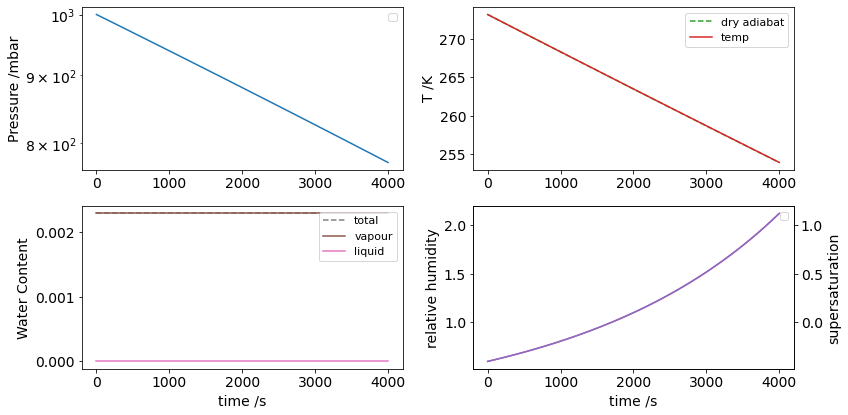

In [557]:
# plots of time evolution of water as parcel rises

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axs = axs.flatten()

axplt(axs[0], t, p/100, ylab='Pressure /mbar', c=0)
axplt(axs[1], t, dry_adia, lab='dry adiabat', c=2, l='--')
axplt(axs[1], t, temp, ylab='T /K', lab='temp', c=3)

axplt(axs[2], t, qv+qc, lab='total', c=7, l='--')
axplt(axs[2], t, qv, lab='vapour', c=5)
axplt(axs[2], t, qc, xlab="time /s", 
    ylab='Water Content', lab='liquid', c=6)

ax3b = axs[3].twinx()
axplt(ax3b, t, s, ylab="supersaturation", c=4)
axplt(axs[3], t, relh, 
    xlab="time /s", ylab='relative humidity', c=4)

for ax in axs:
  ax.legend(fontsize=11, loc='upper right')
axs[0].set_yscale("log")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


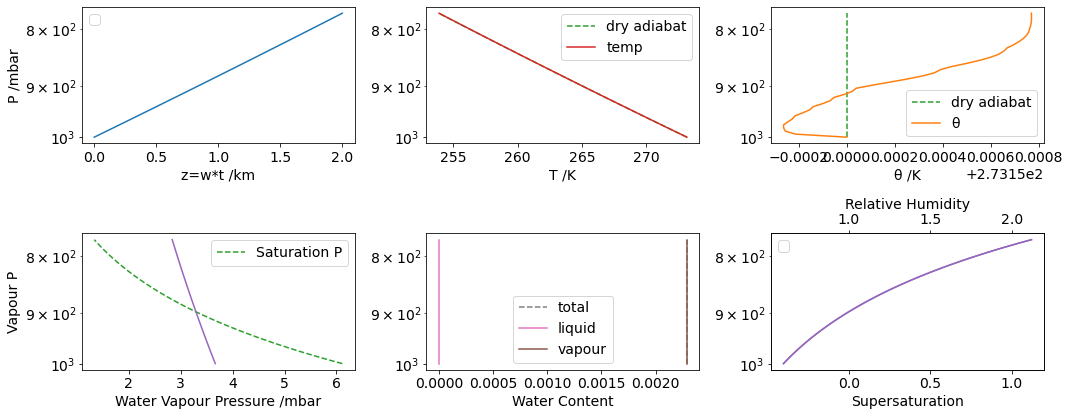

In [558]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,6))
axs = axs.flatten()

axplt(axs[0],  z/1000, p/100, 'z=w*t /km', 'P /mbar', c=0)
axplt(axs[1], dry_adia, p/100, lab='dry adiabat', c=2, l='--')
axplt(axs[1], temp, p/100, 'T /K', lab='temp', c=3)
axplt(axs[2], dry_adia_theta, p/100, lab='dry adiabat', c=2, l='--')
axplt(axs[2], theta, p/100, '\u03B8 /K', lab='\u03B8', c=1)

axplt(axs[4], qv+qc, p/100, lab='total', c=7, l='--')
axplt(axs[4], qc, p/100, lab='liquid', c=6)
axplt(axs[4], qv, p/100, 'Water Content', lab='vapour', c=5)


axplt(axs[3], psat/100, p/100, lab='Saturation P', c=2, l='--')
axplt(axs[3], pv/100, p/100, 
        'Water Vapour Pressure /mbar','Vapour P', c=4)

ax5b = axs[5].twiny()
axplt(ax5b, pv/psat, p/100, 'Relative Humidity', c=4)
axplt(axs[5], s, p/100, 'Supersaturation' , c=4)

for ax in axs:
    ax.legend()
    ax.set_yscale('log')
    ax.invert_yaxis()

fig.tight_layout()
plt.savefig("solution.png", dpi=400, bbox_inches="tight", facecolor='w')
#plt.close()


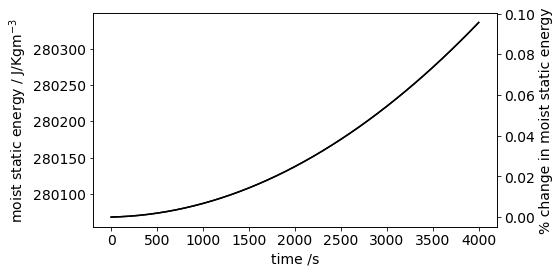

In [559]:
### Moist Static Energy Conservation
mse = moist_static_energy(z, temp, qv)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

axplt(ax, t, mse, xlab ="time /s", 
  ylab='moist static energy / J/Kgm$^{-3}$', c="k")
axb = ax.twinx()
axplt(axb, t, ((mse-mse[0])/mse[0]*100), 
  ylab='% change in moist static energy', c="k")

plt.tight_layout()
plt.show()

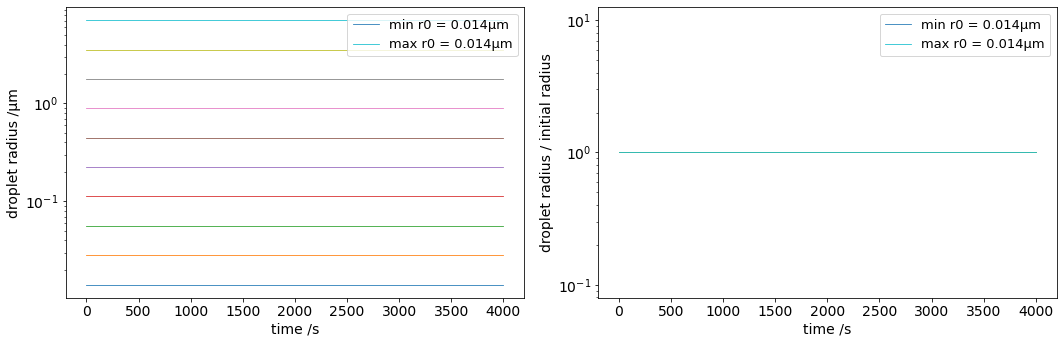

In [560]:
### plots of droplet radii growth
a=1
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r[:,0]]
for i in range(nsupers)[::a]:
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax1.plot(t, r[:,i]*1e6, linewidth=0.8, label=label)
ax1.set_xlabel('time /s')
ax1.set_ylabel('droplet radius /\u03BCm')
ax1.set_yscale('log')
ax1.legend(fontsize=13)

for i in range(nsupers)[::a]:    
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax2.plot(t, r[:,i]/r[0,i], linewidth=0.8, label=label) #,color=cols[i])
ax2.set_xlabel('time /s')
ax2.set_ylabel('droplet radius / initial radius')
ax2.set_yscale('log')
ax2.legend(fontsize=13)

plt.tight_layout()
plt.savefig("SDsolution.png", dpi=400, bbox_inches="tight", facecolor='w')
plt.show()

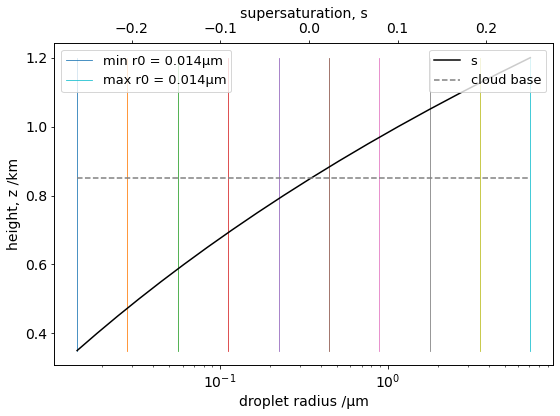

In [561]:
lim1 = basei-10
lim2 = np.argmin(abs(z-cloud_base-400))
### plots of droplet radii growth
fig, ax = plt.subplots(figsize=(8,6))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r[:,0]]
for i in range(nsupers):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax.plot((r[:,i]*1e6)[lim1:lim2], z[lim1:lim2]/1000, linewidth=0.8, label=label)

axb = ax.twiny()
axb.plot(s[lim1:lim2], z[lim1:lim2]/1000, 
         linewidth=1.5, color='k', label='s')
axb.hlines(z[basei]/1000, np.amin(s[lim1:lim2]), np.amax(s[lim1:lim2]), 
         color='gray', linestyle='--', label='cloud base')

ax.set_ylabel('height, z /km')
ax.set_xlabel('droplet radius /\u03BCm')
axb.set_xlabel('supersaturation, s')
ax.set_xscale('log')
ax.legend(fontsize=13, loc='upper left')
axb.legend(fontsize=13,  loc='upper right')

fig.tight_layout()

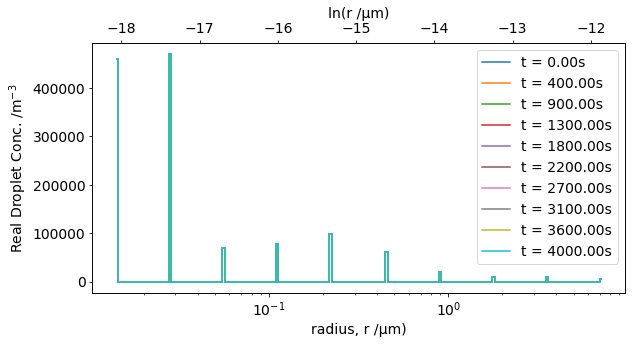

In [562]:
fig, ax = plt.subplots(figsize=(9,5))
nplts = 10
nbins = 200
rspan = [np.amin(r), np.amax(r)]
tplt = np.linspace(t[0], t[-1], nplts)
#tplt = np.linspace(1650, 1750, nplts)
linear_twinax(ax, np.log(r[0,:]), eps[0,:]/VOL)
for i in range(nplts):
    ind = np.argmin(abs(t-tplt[i]))
    tlab = 't = {:.2f}s'.format(t[ind])
    c = 'C'+str(i)
    logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]/VOL, ax=ax,
        step=True, lab=tlab, c='C'+str(i), ylab="Real Droplet Conc. /m$^{-3}$")
#ax.set_yscale('log')
ax.legend()
plt.tight_layout()

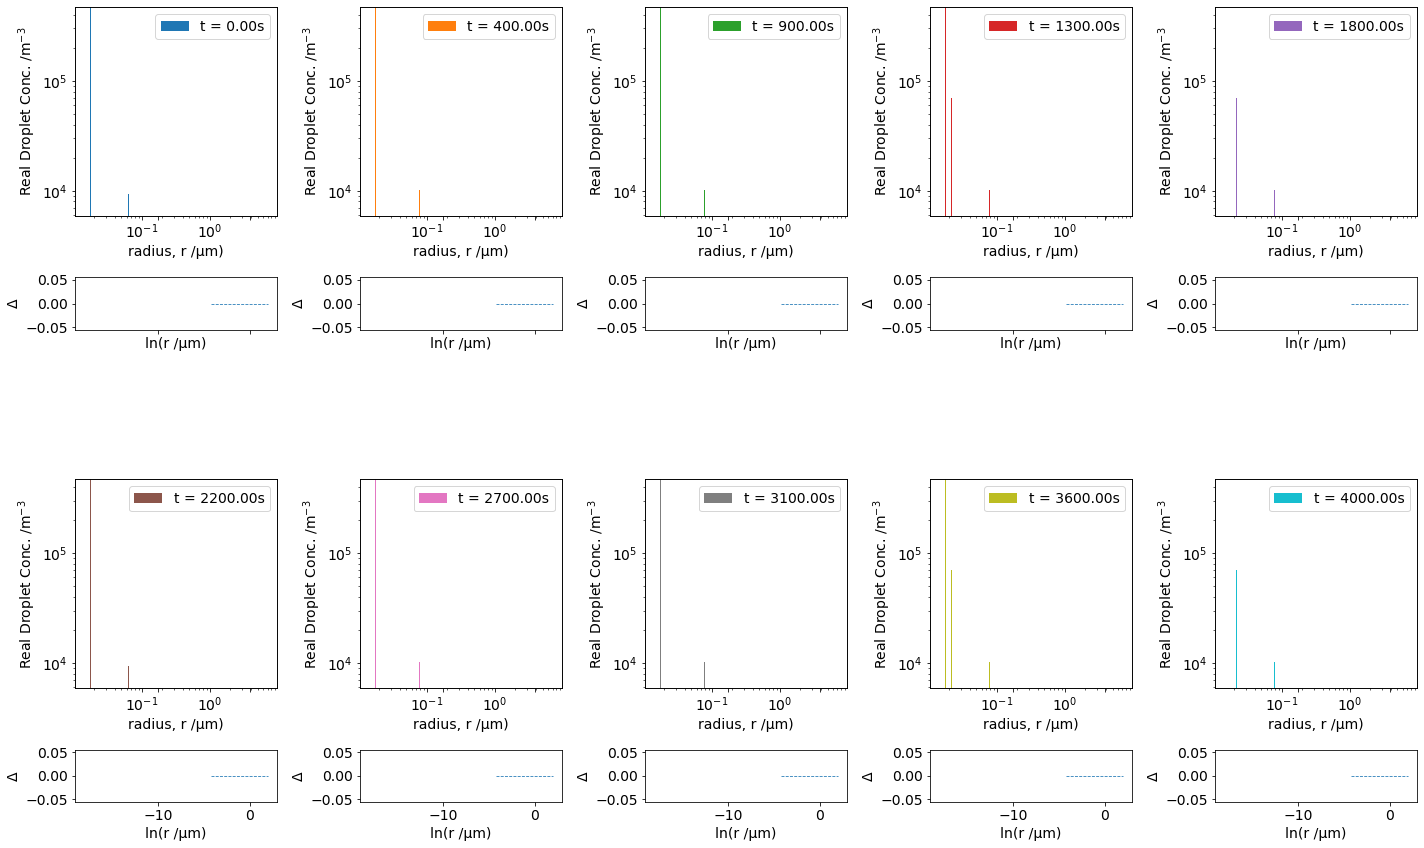

In [563]:
nplts = 10
nbins = 200
rspan = [np.amin(r), np.amax(r)]
tplt = np.linspace(t[0], t[-1], nplts)
#tplt = np.linspace(1650, 1750, nplts)
ncols = 5
hist0, hedgs0 = logr_distribution(rspan, nbins, r[0,:], eps[0,:]/VOL)

gd = dict(width_ratios=[1]*ncols, height_ratios=[8,2,1,8,2],)
fig, axs = plt.subplots(ncols=5, nrows=5, 
            figsize=(20,12), gridspec_kw=gd, sharex=True)


def histogram_subplot(axa, tplt, c, rspan, nbins, t, r, eps):   
    
    ind = np.argmin(abs(t-tplt))
    tlab = 't = {:.2f}s'.format(t[ind])
    hist, hedgs = logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]/VOL, ax=axa,
        lab=tlab, c=c, ylab="Real Droplet Conc. /m$^{-3}$")
    axa.set_yscale('log') 
    axa.set_xlabel(None)
    
    return hist, hedgs


def barchart_subplot(axa, axb, cens, bars, wdths, rspan, c):
    
    axb.bar(cens+np.log(1e6), bars, wdths, color=c) 
    axb.hlines(0, np.log(rspan[0])+np.log(1e6),
                        np.log(rspan[-1])+np.log(1e6), linestyle='--', linewidth=0.8)
    axb.set_xlabel('ln(r /\u03BCm)')
    axb.set_ylabel('\u0394')

for ax in axs[2,:]:
    ax.set_axis_off()

i = 0
ylimsa = [np.amin(hist0[hist0!=0]), np.amax(hist0)]
for rw in [0,3]:
    for col in range(ncols):
        axa = axs[rw, col]
        axb = axs[rw+1, col]

        hist, hedgs = histogram_subplot(axa, tplt[i], 
                    'C'+str(i), rspan, nbins, t, r, eps) 
        linear_twinax(axa, np.log(r[0,:]), eps[0,:])
        
        hcens = (hedgs[1:]+hedgs[:-1])/2                     
        hwdths = hedgs[1:]- hedgs[:-1]                                         
        barchart_subplot(axa, axb, hcens, hist-hist0, hwdths, rspan, 'C'+str(i))
        
        if np.amin(hist) < ylimsa[0]:
            ylimsa[0] = np.amin(hist[hist!=0])
        if np.amax(hist) > ylimsa[1]:
            ylimsa[1] = np.amax(hist)
        
        i+=1

for rw in [0,3]:
    for col in range(ncols):
        axs[rw, col].set_ylim(ylimsa)
#         axs[rw, col].set_yscale("linear")
    

plt.tight_layout()
#plt.savefig("SDdistribution.png", dpi=400, bbox_inches="tight", facecolor='w')

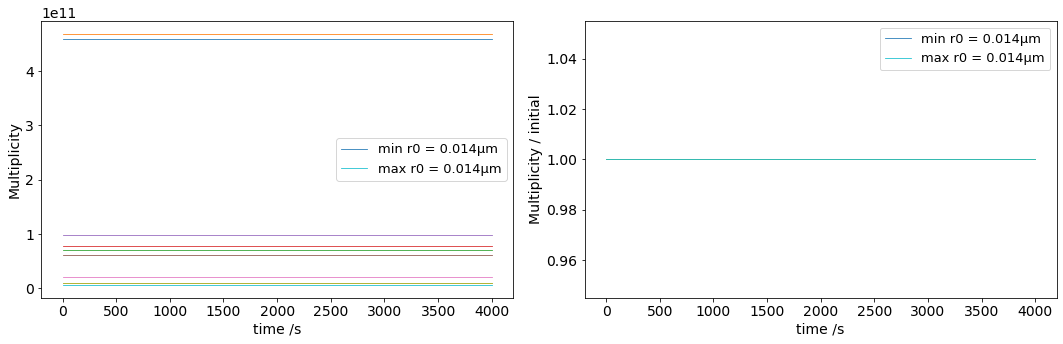

In [564]:
### plots of droplet epsilon changes
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r[:,0]]
for i in range(nsupers):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax1.plot(t, eps[:,i], linewidth=0.8, label=label)
ax1.set_xlabel('time /s')
ax1.set_ylabel('Multiplicity')
#ax1.set_yscale('log')
ax1.legend(fontsize=13)

for i in range(nsupers):    
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax2.plot(t, eps[:,i]/eps[0,i], linewidth=0.8, label=label) #,color=cols[i])

ax2.set_xlabel('time /s')
ax2.set_ylabel('Multiplicity / initial')
#ax2.set_yscale('log')
ax2.legend(fontsize=13)

plt.tight_layout()
plt.show()